In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.graph_objects as go


## SALUD

In [37]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_salud.xlsx"

df_salud = pd.read_excel(ipc_file)

# Asegurarse de que 'VALOR' esté en formato numérico
df_salud["VALOR"] = pd.to_numeric(df_salud["VALOR"], errors="coerce")

# Asumir que las categorías son las mismas
categorias = df_salud["CATEGORIA"].unique().tolist()

# Pesos  proporcionados
pesos_manual = [
    0.016, 0.159, 0.137, 0.107, 0.065, 0.182, 0.058, 0.085, 0.024, 0.237
]

# NORMALIZACIÓN 
w_salud = 3.475

suma_original = sum(pesos_manual)
factor = w_salud / suma_original
pesos_norm = [p * factor for p in pesos_manual]

# print("\nSuma original:", suma_original)
# print("Suma normalizada:", sum(pesos_norm))

# Crear dataframe de pesos
df_pesos = pd.DataFrame({
    "CATEGORIA": categorias,
    "PESO": pesos_manual,
    "PESO_NORMALIZADO": pesos_norm
})


# Convertir los pesos normalizados a una matriz NumPy
w = np.array(pesos_norm)

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Crear el diccionario de IPC por fecha
ipc_salud = {}

# Asegurarse de que 'FECHA' sea una columna válida en df_salud, y ordenarla por fecha
for fecha in df_salud["FECHA"].unique(): 
    # Filtramos los datos para esa fecha y agrupamos por 'CATEGORIA'
    valores = df_salud[df_salud["FECHA"] == fecha]["VALOR"].values
    ipc_salud[fecha] = geom_pond(valores, w)  # Usamos los valores de la columna 'VALOR'

# Convertir a una serie final ordenada por fecha
ipc_salud = pd.Series(ipc_salud)
ipc_salud.index = pd.to_datetime(ipc_salud.index)
ipc_salud = ipc_salud.sort_index()

#######################################################################
# Convertir ipc_salud a DataFrame para concatenarlo con df_salud
df_ipc_salud = ipc_salud.reset_index()
df_ipc_salud.columns = ["FECHA", "VALOR"]

# Agregar un identificador de categoría general para el IPC
df_ipc_salud["CATEGORIA"] = "Índice Salud"

# Concatenar los datos originales con la fila calculada para IPC
df_salud = pd.concat([df_salud, df_ipc_salud], ignore_index=True)


# Crear el gráfico
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ipc_salud.index,
    y=ipc_salud.values,
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()
fig.write_image("results/indice_salud.pdf")

## ALIMENTOS 

In [38]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_alimentos.xlsx"

df_alimentos = pd.read_excel(ipc_file)

df_alimentos["VALOR"] = pd.to_numeric(df_alimentos["VALOR"], errors="coerce")

categorias_alimentos = df_alimentos["CATEGORIA"].unique().tolist()

# Pesos manuales para la división de alimentos
pesos_alimentos = [
    0.384, 1.373, 0.268, 0.103, 1.210, 0.369, 0.206, 3.070, 1.346,
    0.182, 0.184, 0.192, 0.354, 0.354, 2.425, 0.151, 0.096, 0.255,
    0.619, 0.706, 1.303, 0.022, 0.320, 0.075, 0.322, 0.106, 0.137,
    0.059, 2.134, 0.523, 0.220, 0.211, 0.060, 0.095, 0.316
]

# NORMALIZACIÓN 
w_alimentos = 23.928  # Definir w_alimentos 

suma_original = sum(pesos_alimentos)
factor = w_alimentos / suma_original
pesos_norm_alimentos = [p * factor for p in pesos_alimentos]

# Crear dataframe de pesos para alimentos
df_pesos_alimentos = pd.DataFrame({
    "CATEGORIA": categorias_alimentos,
    "PESO": pesos_alimentos,
    "PESO_NORMALIZADO": pesos_norm_alimentos
})

# Convertir los pesos normalizados a una matriz NumPy
w_alimentos = np.array(pesos_norm_alimentos)

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Crear el diccionario de IPC por fecha
ipc_alimentos = {}

# Asegurarse de que 'FECHA' sea una columna válida en df_alimentos
for fecha in df_alimentos["FECHA"].unique(): 
    # Filtramos los datos para esa fecha y agrupamos por 'CATEGORIA'
    valores = df_alimentos[df_alimentos["FECHA"] == fecha]["VALOR"].values
    ipc_alimentos[fecha] = geom_pond(valores, w_alimentos)  # Usamos los valores de la columna 'VALOR'

# Convertir a una serie final ordenada por fecha
ipc_alimentos = pd.Series(ipc_alimentos)
ipc_alimentos.index = pd.to_datetime(ipc_alimentos.index)
ipc_alimentos = ipc_alimentos.sort_index()

# Convertir ipc_alimentos a DataFrame para concatenarlo con df_alimentos
df_ipc_alimentos = ipc_alimentos.reset_index()
df_ipc_alimentos.columns = ["FECHA", "VALOR"]

# Agregar un identificador de categoría general para el IPC de alimentos
df_ipc_alimentos["CATEGORIA"] = "Índice Alimentos"

# Concatenar los datos originales con la fila calculada para IPC
df_alimentos = pd.concat([df_alimentos, df_ipc_alimentos], ignore_index=True)


#######################################################################
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ipc_alimentos.index,
    y=ipc_alimentos.values,
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()

fig.write_image("results/indice_alimentos.pdf")



## EDUCACIÓN

In [39]:
dir_input = Path("data/base100/")
df_educacion = dir_input / "base_educacion.xlsx"

df_educacion = pd.read_excel(df_educacion)

# Asegurarse de que 'VALOR' esté en formato numérico
df_educacion["VALOR"] = pd.to_numeric(df_educacion["VALOR"], errors="coerce")

# Pesos para la división Educación
pesos_educacion = [
    0.691,
    1.553,
    1.259
]

# Normalización
w_educacion = 8.058  # Peso total de la división

suma_original = sum(pesos_educacion)
factor = w_educacion / suma_original
pesos_norm_educacion = [p * factor for p in pesos_educacion]

# Crear dataframe de pesos
categorias_educacion = df_educacion["CATEGORIA"].unique().tolist()
df_pesos_educacion = pd.DataFrame({
    "CATEGORIA": categorias_educacion,
    "PESO": pesos_educacion,
    "PESO_NORMALIZADO": pesos_norm_educacion
})

# Convertir los pesos normalizados a una matriz NumPy
w_educacion = np.array(pesos_norm_educacion)

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Crear el diccionario de IPC por fecha
ipc_educacion = {}
for fecha in df_educacion["FECHA"].unique(): 
    valores = df_educacion[df_educacion["FECHA"] == fecha]["VALOR"].values
    ipc_educacion[fecha] = geom_pond(valores, w_educacion)

# Convertir a una serie final ordenada por fecha
ipc_educacion = pd.Series(ipc_educacion)
ipc_educacion.index = pd.to_datetime(ipc_educacion.index)
ipc_educacion = ipc_educacion.sort_index()

# Concatenar IPC con el dataframe original
df_ipc_educacion = ipc_educacion.reset_index()
df_ipc_educacion.columns = ["FECHA", "VALOR"]
df_ipc_educacion["CATEGORIA"] = "Índice Educación"

# Concatenar datos originales con el IPC
df_educacion = pd.concat([df_educacion, df_ipc_educacion], ignore_index=True)

# Crear el gráfico de IPC de Educación
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ipc_educacion.index,
    y=ipc_educacion.values,
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()
fig.write_image("results/indice_educacion.pdf")


## TRANSPORTE

In [40]:
dir_input = Path("data/base100/")
df_combustibles = dir_input / "base_combustibles.xlsx"
df_combustibles = pd.read_excel(df_combustibles)

# Asegurarse de que 'VALOR' esté en formato numérico
df_combustibles["VALOR"] = pd.to_numeric(df_combustibles["VALOR"], errors="coerce")

# Pesos para la división Combustibles
pesos_combustibles = [
    12.210
]

# Normalización
w_combustibles = 12.210  # Peso total de la división

suma_original = sum(pesos_combustibles)
factor = w_combustibles / suma_original
pesos_norm_combustibles = [p * factor for p in pesos_combustibles]

# Crear dataframe de pesos
categorias_combustibles = df_combustibles["CATEGORIA"].unique().tolist()
df_pesos_combustibles = pd.DataFrame({
    "CATEGORIA": categorias_combustibles,
    "PESO": pesos_combustibles,
    "PESO_NORMALIZADO": pesos_norm_combustibles
})

# Convertir los pesos normalizados a una matriz NumPy
w_combustibles = np.array(pesos_norm_combustibles)

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Crear el diccionario de IPC por fecha
ipc_combustibles = {}
for fecha in df_combustibles["FECHA"].unique(): 
    valores = df_combustibles[df_combustibles["FECHA"] == fecha]["VALOR"].values
    ipc_combustibles[fecha] = geom_pond(valores, w_combustibles)

# Convertir a una serie final ordenada por fecha
ipc_combustibles = pd.Series(ipc_combustibles)
ipc_combustibles.index = pd.to_datetime(ipc_combustibles.index)
ipc_combustibles = ipc_combustibles.sort_index()

# Concatenar IPC con el dataframe original
df_ipc_combustibles = ipc_combustibles.reset_index()
df_ipc_combustibles.columns = ["FECHA", "VALOR"]
df_ipc_combustibles["CATEGORIA"] = "Índice Combustibles"

# Concatenar datos originales con el IPC
df_combustibles = pd.concat([df_combustibles, df_ipc_combustibles], ignore_index=True)

# Crear el gráfico de IPC de Combustibles
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ipc_combustibles.index,
    y=ipc_combustibles.values,
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()
fig.write_image("results/indice_combustibles.pdf")


## VIVIENDA


In [41]:
dir_input = Path("data/base100/")
ipc_file = dir_input / "base_vivienda.xlsx"
df_vivienda = pd.read_excel(ipc_file)

# Asegurarse de que 'VALOR' esté en formato numérico
df_vivienda["VALOR"] = pd.to_numeric(df_vivienda["VALOR"], errors="coerce")

# Pesos para la división Vivienda
pesos_vivienda = [
    4.451,
    0.000
]

# Normalización
w_vivienda = 9.607  # Peso total de la división

suma_original = sum(pesos_vivienda)
factor = w_vivienda / suma_original
pesos_norm_vivienda = [p * factor for p in pesos_vivienda]

# Crear dataframe de pesos
categorias_vivienda = df_vivienda["CATEGORIA"].unique().tolist()
df_pesos_vivienda = pd.DataFrame({
    "CATEGORIA": categorias_vivienda,
    "PESO": pesos_vivienda,
    "PESO_NORMALIZADO": pesos_norm_vivienda
})

# Convertir los pesos normalizados a una matriz NumPy
w_vivienda = np.array(pesos_norm_vivienda)

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Crear el diccionario de IPC por fecha
ipc_vivienda = {}
for fecha in df_vivienda["FECHA"].unique(): 
    valores = df_vivienda[df_vivienda["FECHA"] == fecha]["VALOR"].values
    ipc_vivienda[fecha] = geom_pond(valores, w_vivienda)

# Convertir a una serie final ordenada por fecha
ipc_vivienda = pd.Series(ipc_vivienda)
ipc_vivienda.index = pd.to_datetime(ipc_vivienda.index)
ipc_vivienda = ipc_vivienda.sort_index()

# Concatenar IPC con el dataframe original
df_ipc_vivienda = ipc_vivienda.reset_index()
df_ipc_vivienda.columns = ["FECHA", "VALOR"]
df_ipc_vivienda["CATEGORIA"] = "Índice Vivienda"

# Concatenar datos originales con el IPC
df_vivienda = pd.concat([df_vivienda, df_ipc_vivienda], ignore_index=True)

# Crear el gráfico de IPC de Vivienda
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ipc_vivienda.index,
    y=ipc_vivienda.values,
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()
fig.write_image("results/indice_vivienda.pdf")


# ÍNDICE FINAL

In [42]:
# Pesos oficiales de cada división
pesos_div = {
    "ALIMENTOS": 23.928,
    "SALUD": 3.475,
    "EDUCACION": 8.058,
    "COMBUSTIBLES": 12.210,
    "VIVIENDA": 9.607
}

# Suma total oficial
suma_total = sum(pesos_div.values())

# Normalización para que sumen 100
factor = 100 / suma_total
pesos_div_norm = {k: v * factor for k, v in pesos_div.items()}

# Convertir a vector en el mismo orden
divisiones = ["ALIMENTOS", "SALUD", "EDUCACION", "COMBUSTIBLES", "VIVIENDA"]
w = np.array([pesos_div_norm[d] for d in divisiones])
w = w / w.sum()  # Por si acaso

# Función de ponderación geométrica
def geom_pond(x, w):
    x = np.array(x)
    return np.exp(np.sum(w * np.log(x)) / np.sum(w))

# Extraer los índices sectoriales de cada dataframe por fecha
# Para cada sector, extraemos el índice sectorial por fecha
ipc_alimentos = df_alimentos[df_alimentos["CATEGORIA"] == "Índice Alimentos"].set_index("FECHA")["VALOR"]
ipc_salud = df_salud[df_salud["CATEGORIA"] == "Índice Salud"].set_index("FECHA")["VALOR"]
ipc_educacion = df_educacion[df_educacion["CATEGORIA"] == "Índice Educación"].set_index("FECHA")["VALOR"]
ipc_combustibles = df_combustibles[df_combustibles["CATEGORIA"] == "Índice Combustibles"].set_index("FECHA")["VALOR"]
ipc_vivienda = df_vivienda[df_vivienda["CATEGORIA"] == "Índice Vivienda"].set_index("FECHA")["VALOR"]

# Crear el dataframe de IPC por divisiones (por fecha)
ipc_divisiones = pd.DataFrame({
    "ALIMENTOS": ipc_alimentos,
    "SALUD": ipc_salud,
    "EDUCACION": ipc_educacion,
    "COMBUSTIBLES": ipc_combustibles,
    "VIVIENDA": ipc_vivienda
})

# Asegurarnos de que todas las fechas coincidan en cada columna
ipc_divisiones = ipc_divisiones.dropna() 

# Calcular IPC total ponderado por fecha
ipc_total = {}

for fecha in ipc_divisiones.index:
    valores = ipc_divisiones.loc[fecha].values
    ipc_total[fecha] = geom_pond(valores, w)

ipc_total = pd.Series(ipc_total)
ipc_total = ipc_total.sort_index()

# Concatenar IPC total con los dataframes de cada sector
df_ipc_total = ipc_total.reset_index()
df_ipc_total.columns = ["FECHA", "VALOR"]
df_ipc_total["CATEGORIA"] = "IPC"



df_salud['Sector'] = 'Salud'
df_alimentos['Sector'] = 'Alimentos'
df_educacion['Sector'] = 'Educacion'
df_combustibles['Sector'] = 'Transporte'
df_vivienda['Sector'] = 'Alojamiento'
df_ipc_total['Sector'] = 'Total'



# Concatenar todos los dataframes (sectoriales + IPC total)
df_final = pd.concat([df_salud, df_alimentos, df_educacion, df_combustibles, df_vivienda, df_ipc_total], ignore_index=True)

# Crear el gráfico para el IPC total
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ipc_total.index,
    y=ipc_total.values,
    mode="lines",
    name="Índice Total (Base 100)",
    line=dict(width=2)
))

fig.update_layout(
    title=None,
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()

# Guardar el gráfico como un archivo PDF
fig.write_image("results/indice_final.pdf")



c:\Users\jhers\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



In [43]:
# file_path = 'data/all_data.xlsx'
# with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
#     df_final.to_excel(writer, sheet_name='IPC', index=False)


In [44]:
df_final.to_excel("data/data_indices.xlsx")


<Axes: >

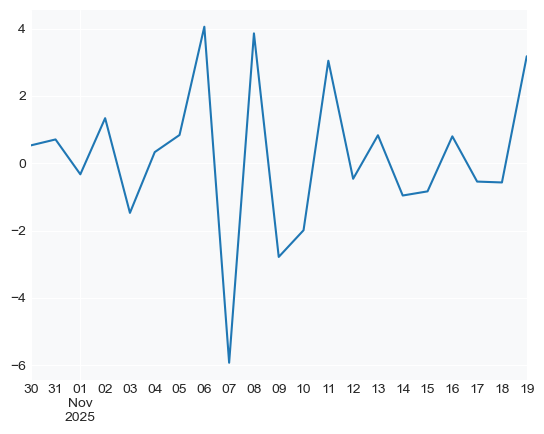

In [45]:
ipc_total.diff().dropna().plot()

In [46]:
df_final

,FECHA,CATEGORIA,VALOR,Sector
0,2025-10-29,ANTICONCEPTIVOS,100.000000,Salud
1,2025-10-29,ANTIINFECCIOSOS SISTÉMICOS,100.000000,Salud
2,2025-10-29,APARATO CARDIOVASCULAR,100.000000,Salud
3,2025-10-29,APARATO DIGESTIVO,100.000000,Salud
4,2025-10-29,APARATO GENITOURINARIO Y REPRODUCTOR,100.000000,Salud
...,...,...,...,...
1254,2025-11-15 00:00:00,IPC,100.753560,Total
1255,2025-11-16 00:00:00,IPC,101.551500,Total
1256,2025-11-17 00:00:00,IPC,101.005108,Total
1257,2025-11-18 00:00:00,IPC,100.433064,Total


In [47]:
# Ahora usaré subplots para mostrar los 6 índices en una sola figura

import plotly.subplots as sp

# Crear el gráfico con subgráficas para los 6 índices
fig = sp.make_subplots(
    rows=3, cols=2,  # 3 filas y 2 columnas
    subplot_titles=[
        "Índice Alimentos", "Índice Salud", "Índice Educación", 
        "Índice Combustibles", "Índice Vivienda", "Índice Total"
    ],
    shared_xaxes=True, shared_yaxes=True,
    vertical_spacing=0.1, horizontal_spacing=0.1
)

# Agregar cada índice a su respectiva subgráfica
indices = [
    ("Índice Alimentos", ipc_alimentos),
    ("Índice Salud", ipc_salud),
    ("Índice Educación", ipc_educacion),
    ("Índice Combustibles", ipc_combustibles),
    ("Índice Vivienda", ipc_vivienda),
    ("Índice Total", ipc_total)
]


for i, (categoria, data) in enumerate(indices):
    row = i // 2 + 1  # Fila (1-3)
    col = i % 2 + 1   # Columna (1-2)
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data.values,
        mode="lines",
        name=categoria,
        line=dict(width=2)
    ), row=row, col=col)


fig.update_layout(
    title=None,#"Índices Ponderados por Sector",
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=1000,
    height=900
)

fig.show()


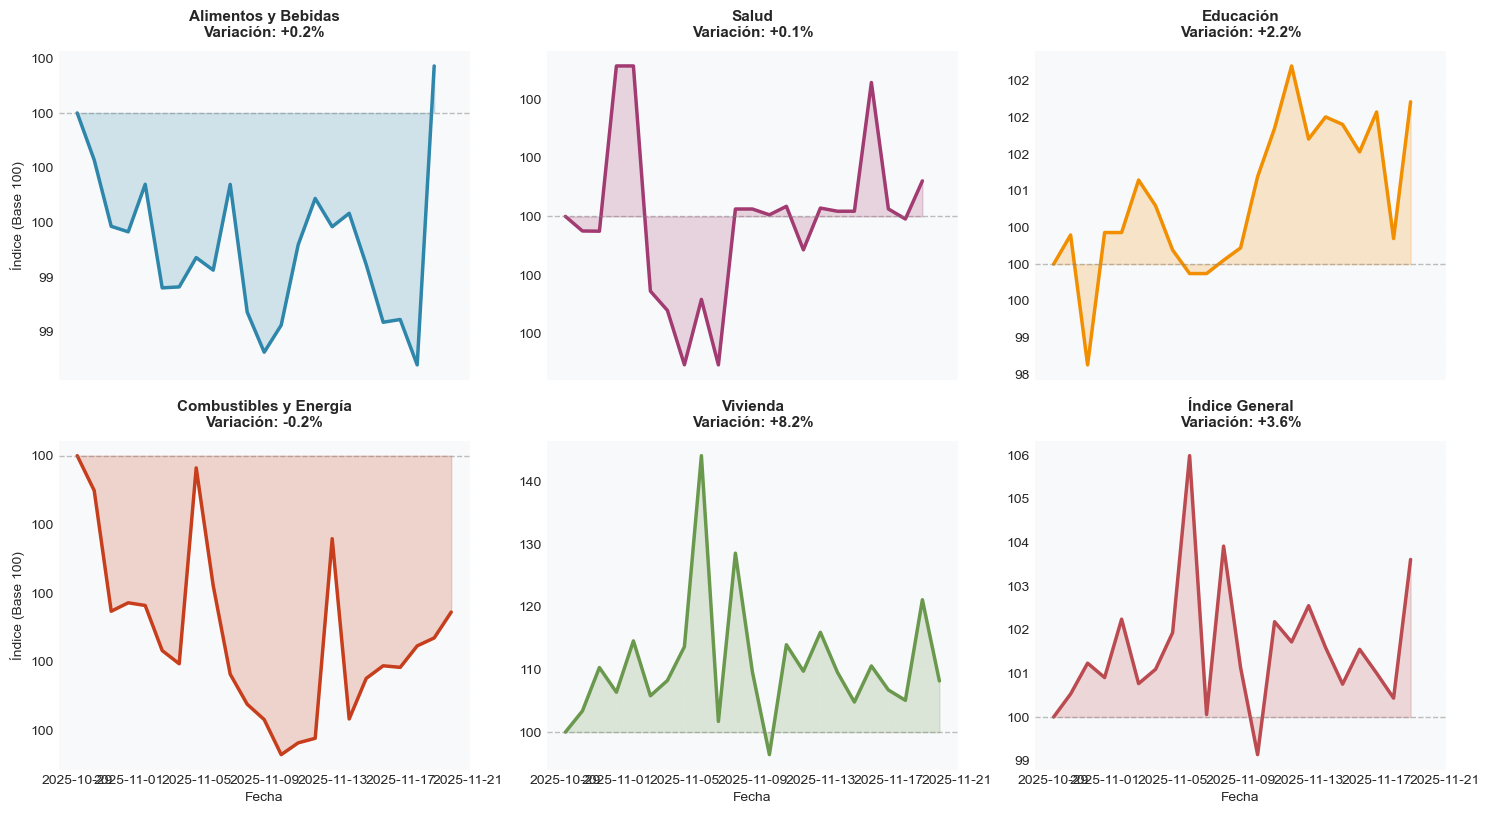

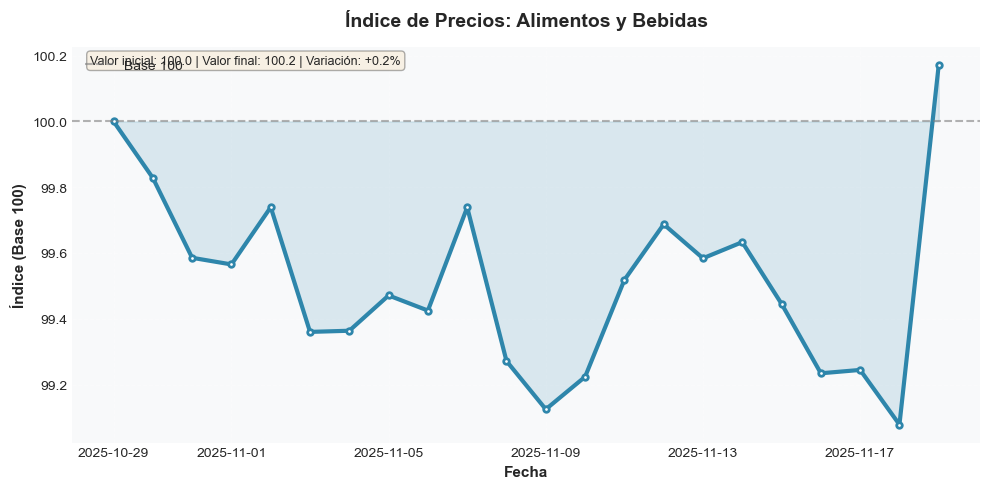

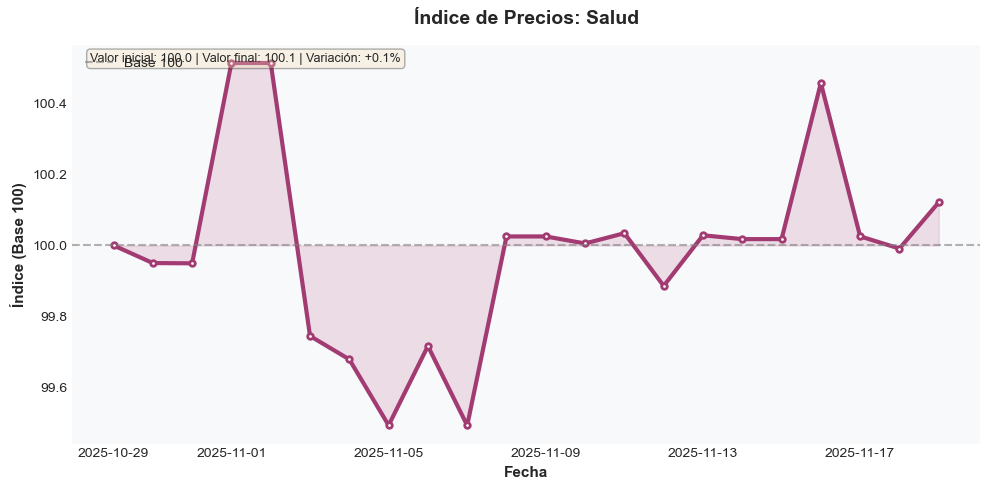

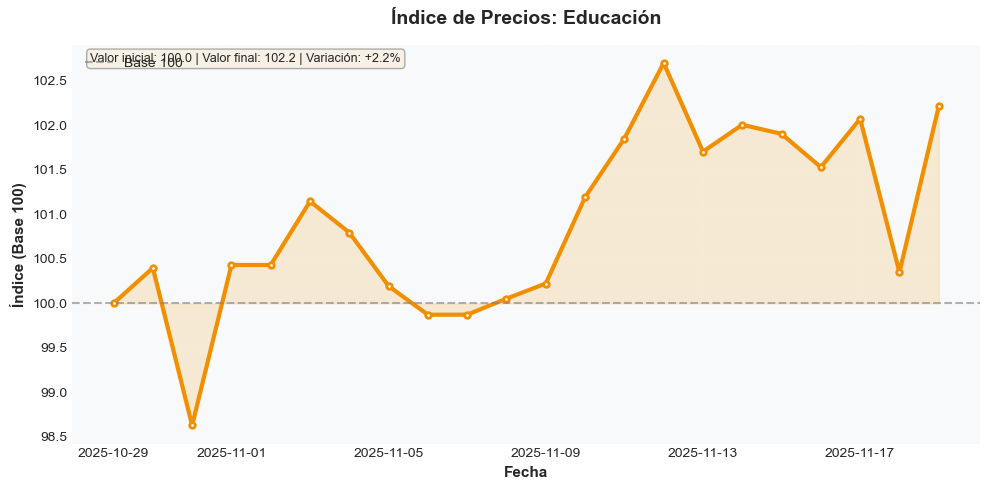

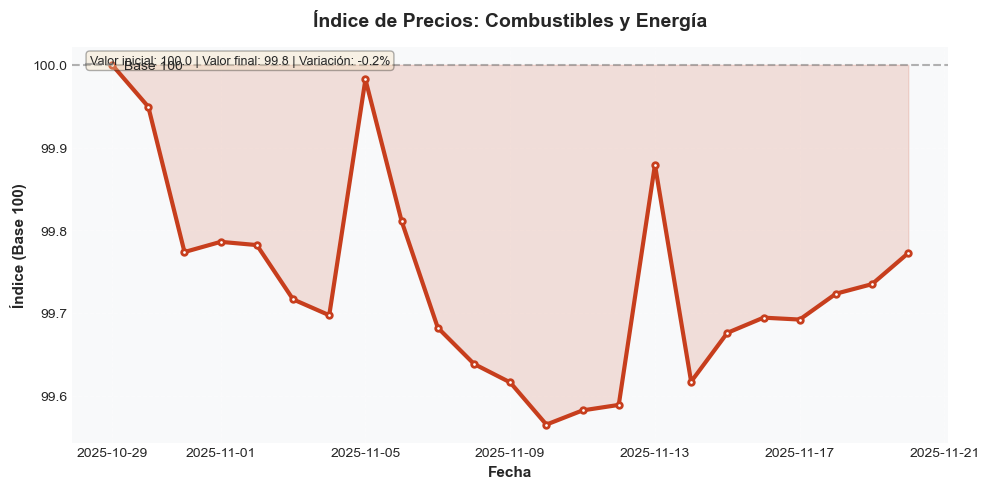

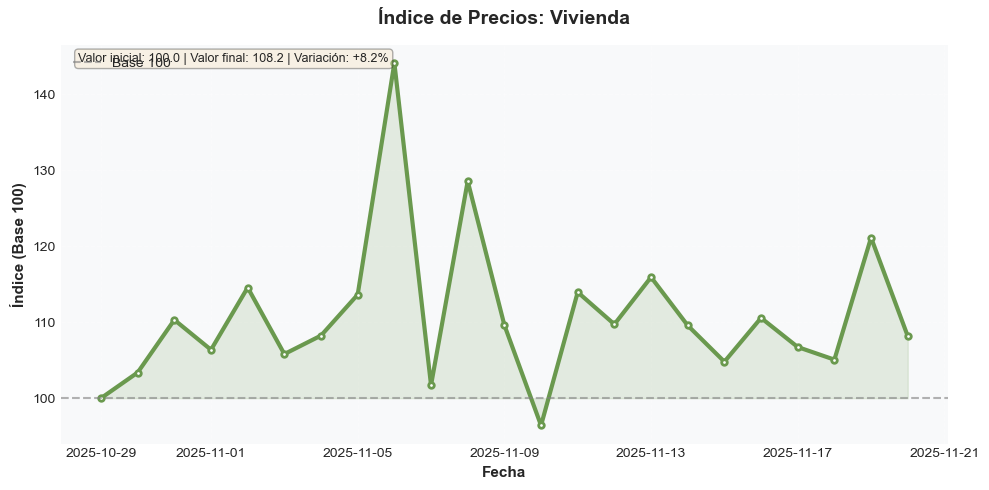

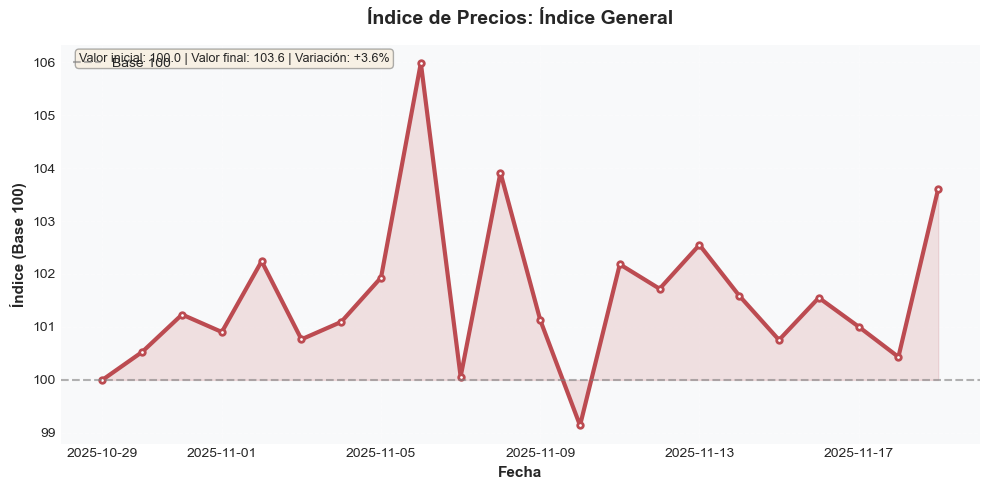

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuración general de estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'





fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

indices = [
    ("Alimentos y Bebidas", ipc_alimentos, '#2E86AB'),
    ("Salud", ipc_salud, '#A23B72'),
    ("Educación", ipc_educacion, '#F18F01'),
    ("Combustibles y Energía", ipc_combustibles, '#C73E1D'),
    ("Vivienda", ipc_vivienda, '#6A994E'),
    ("Índice General", ipc_total, '#BC4B51')
]

for i, (categoria, data, color) in enumerate(indices):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Graficar línea principal
    ax.plot(data.index, data.values, linewidth=2.5, color=color, label=categoria)
    
    # Agregar área sombreada
    ax.fill_between(data.index, 100, data.values, alpha=0.2, color=color)
    
    # Línea de referencia en 100
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Calcular variación porcentual
    var_total = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    
    # Título con información
    ax.set_title(f'{categoria}\nVariación: {var_total:+.1f}%', 
                fontweight='bold', fontsize=11, pad=10)
    
    # Etiquetas
    if row == 1:
        ax.set_xlabel("Fecha", fontsize=10)
    if col == 0:
        ax.set_ylabel("Índice (Base 100)", fontsize=10)
    
    # Grid mejorado
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Formato de eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

plt.tight_layout()
plt.subplots_adjust(top=0.96)

plt.show()











for categoria, data, color in indices:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Graficar con estilo
    ax.plot(data.index, data.values, linewidth=3, color=color, marker='o', 
            markersize=4, markerfacecolor='white', markeredgewidth=2)
    
    # Área sombreada
    ax.fill_between(data.index, 100, data.values, alpha=0.15, color=color)
    
    # Línea base
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, 
               label='Base 100')
    
    # Estadísticas
    var_total = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    valor_inicial = data.iloc[0]
    valor_final = data.iloc[-1]
    
    # Título y subtítulo
    ax.set_title(f'Índice de Precios: {categoria}', 
                fontsize=14, fontweight='bold', pad=15)
    ax.text(0.02, 0.98, 
            f'Valor inicial: {valor_inicial:.1f} | Valor final: {valor_final:.1f} | Variación: {var_total:+.1f}%',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Etiquetas
    ax.set_xlabel("Fecha", fontsize=11, fontweight='bold')
    ax.set_ylabel("Índice (Base 100)", fontsize=11, fontweight='bold')
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Leyenda
    ax.legend(loc='upper left', framealpha=0.9)
    
    plt.tight_layout()

    plt.show()

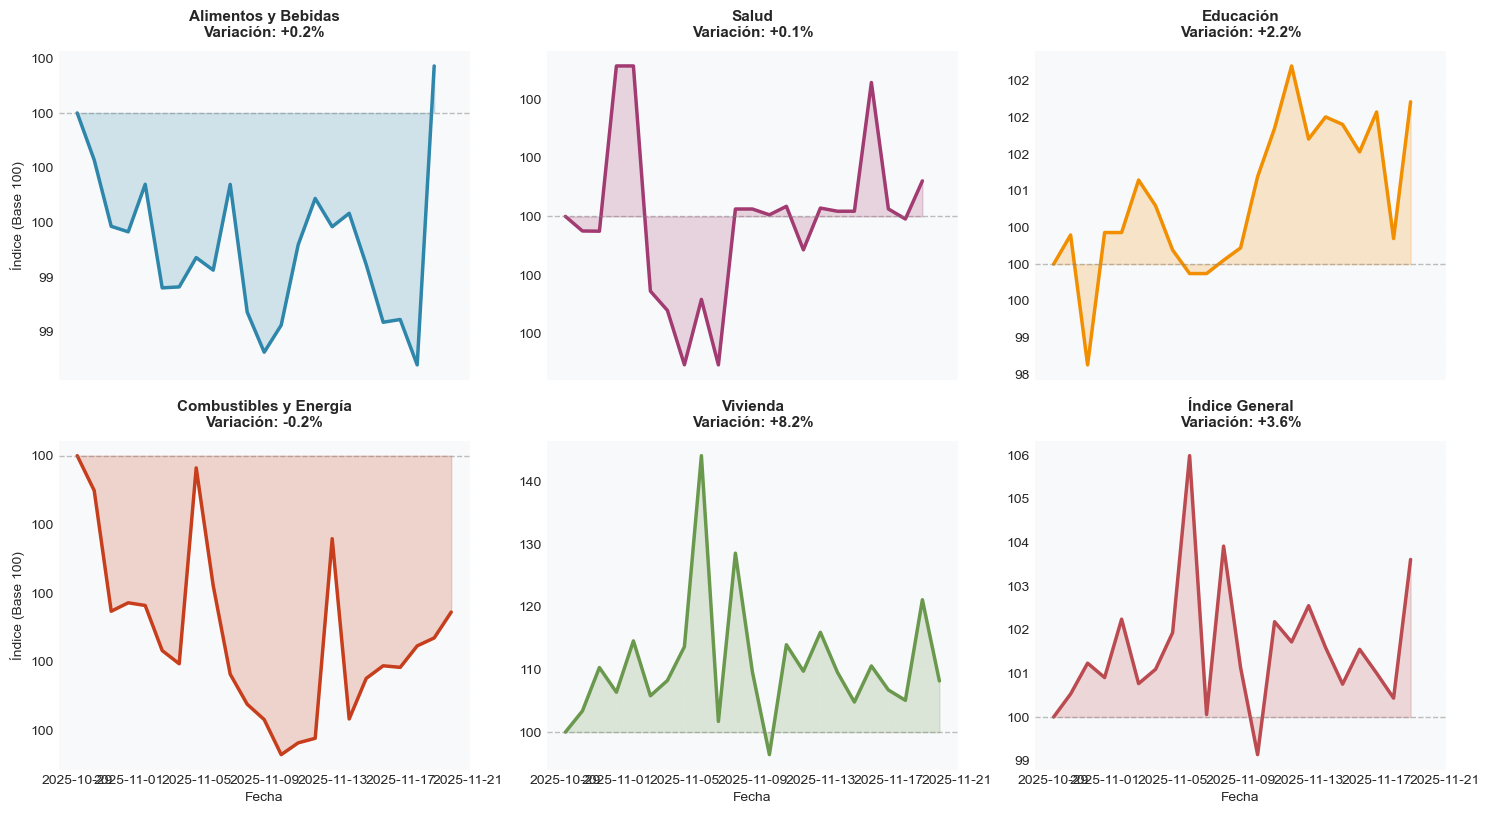

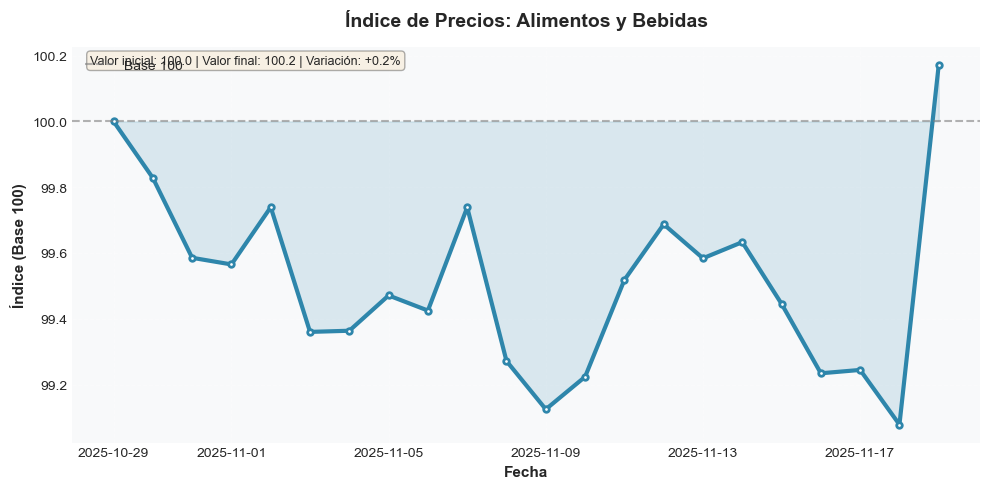

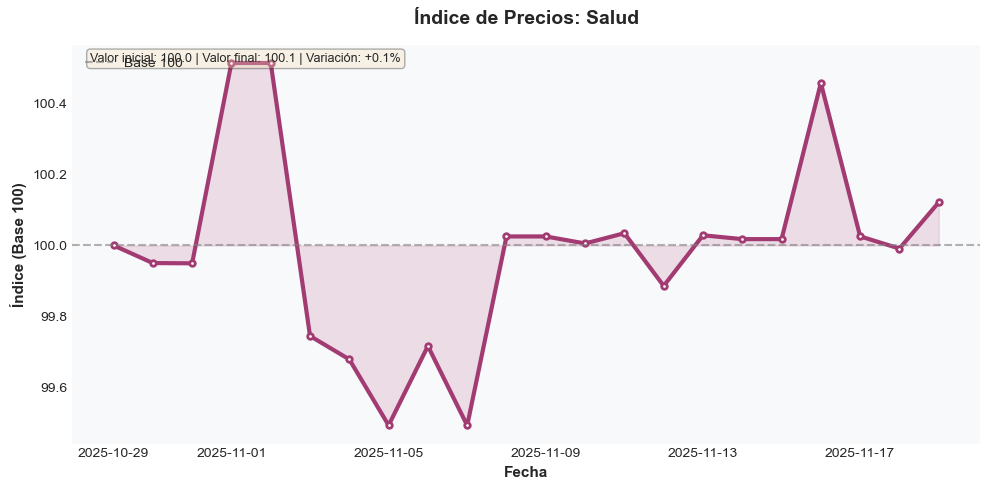

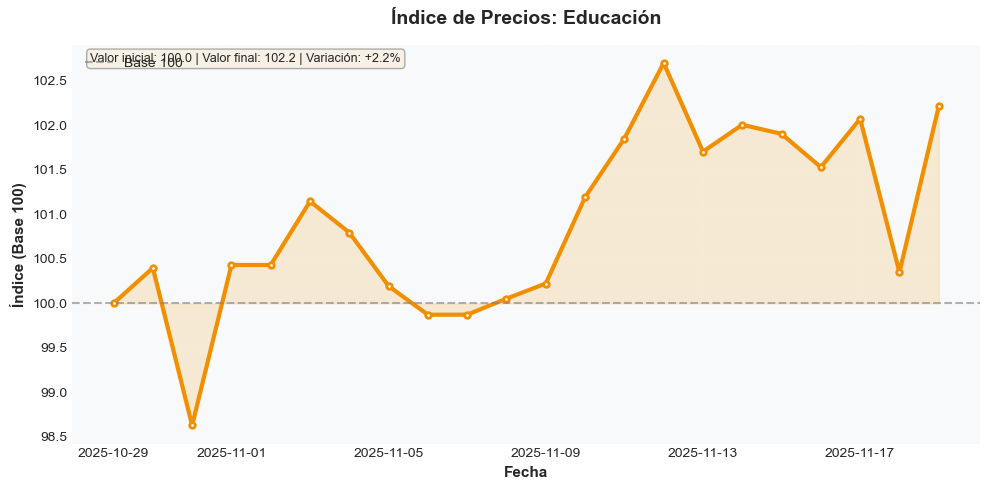

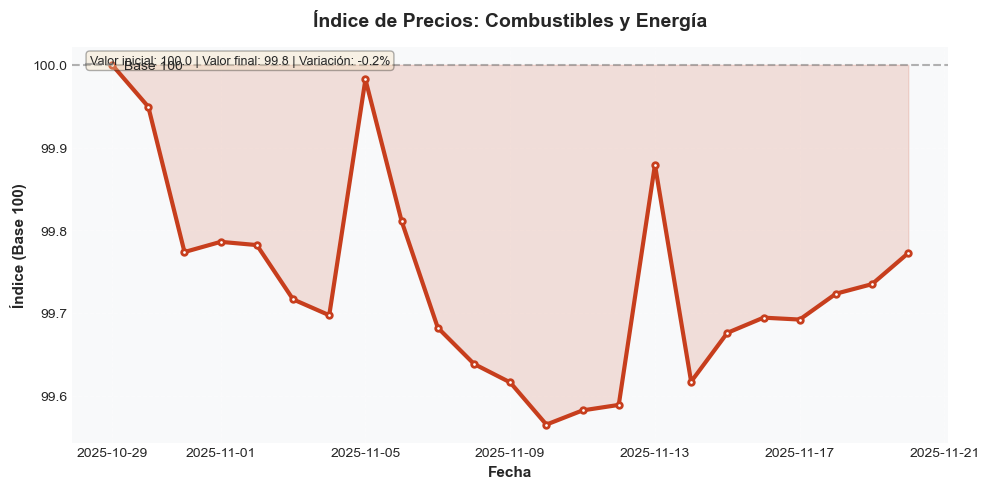

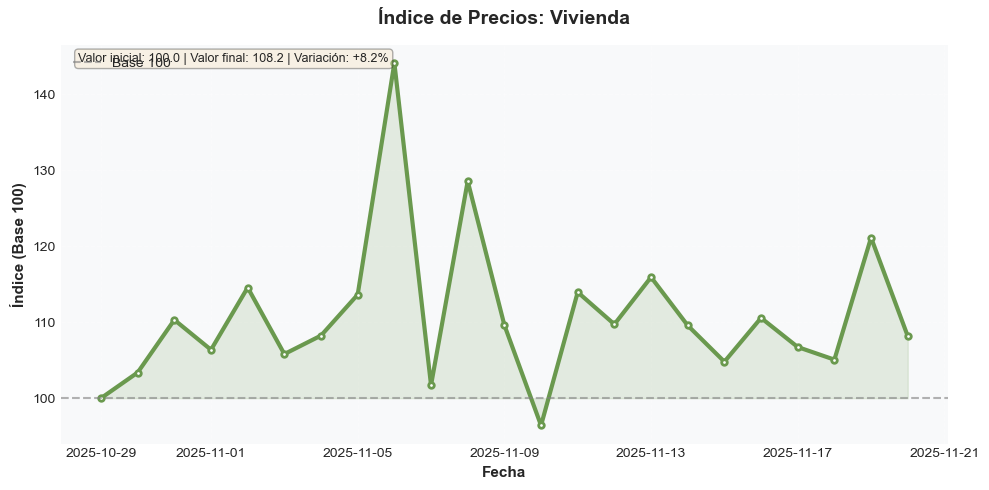

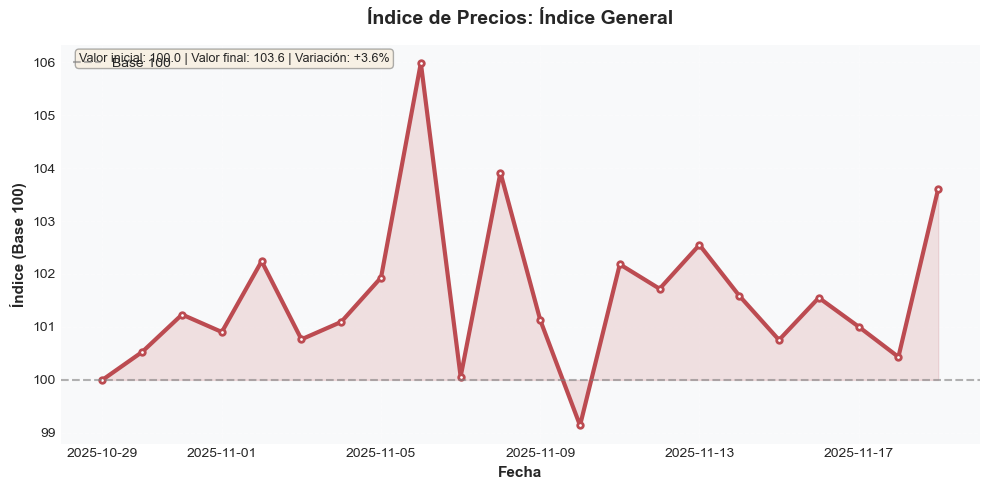

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuración general de estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'

# Crear subgráficos
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

# Definir categorías y colores
indices = [
    ("Alimentos y Bebidas", ipc_alimentos, '#2E86AB'),
    ("Salud", ipc_salud, '#A23B72'),
    ("Educación", ipc_educacion, '#F18F01'),
    ("Combustibles y Energía", ipc_combustibles, '#C73E1D'),
    ("Vivienda", ipc_vivienda, '#6A994E'),
    ("Índice General", ipc_total, '#BC4B51')
]

# Graficar cada categoría
for i, (categoria, data, color) in enumerate(indices):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Graficar línea principal
    ax.plot(data.index, data.values, linewidth=2.5, color=color, label=categoria)
    
    # Agregar área sombreada
    ax.fill_between(data.index, 100, data.values, alpha=0.2, color=color)
    
    # Línea de referencia en 100
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Calcular variación porcentual
    var_total = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    
    # Título con información
    ax.set_title(f'{categoria}\nVariación: {var_total:+.1f}%', 
                fontweight='bold', fontsize=11, pad=10)
    
    # Etiquetas
    if row == 1:
        ax.set_xlabel("Fecha", fontsize=10)
    if col == 0:
        ax.set_ylabel("Índice (Base 100)", fontsize=10)
    
    # Grid mejorado
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Formato de eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

# Ajustar el diseño
plt.tight_layout()
plt.subplots_adjust(top=0.96)

# Mostrar gráfico
plt.show()

# Segundo gráfico: uno por uno
for categoria, data, color in indices:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Graficar con estilo
    ax.plot(data.index, data.values, linewidth=3, color=color, marker='o', 
            markersize=4, markerfacecolor='white', markeredgewidth=2)
    
    # Área sombreada
    ax.fill_between(data.index, 100, data.values, alpha=0.15, color=color)
    
    # Línea base
    ax.axhline(y=100, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, 
               label='Base 100')
    
    # Estadísticas
    var_total = ((data.iloc[-1] / data.iloc[0]) - 1) * 100
    valor_inicial = data.iloc[0]
    valor_final = data.iloc[-1]
    
    # Título y subtítulo
    ax.set_title(f'Índice de Precios: {categoria}', 
                fontsize=14, fontweight='bold', pad=15)
    ax.text(0.02, 0.98, 
            f'Valor inicial: {valor_inicial:.1f} | Valor final: {valor_final:.1f} | Variación: {var_total:+.1f}%',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Etiquetas
    ax.set_xlabel("Fecha", fontsize=11, fontweight='bold')
    ax.set_ylabel("Índice (Base 100)", fontsize=11, fontweight='bold')
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Leyenda
    ax.legend(loc='upper left', framealpha=0.9)
    
    # Ajustar el diseño
    plt.tight_layout()

    # Mostrar gráfico
    plt.show()
